## Bu projede  haberlerin  sahte olup olmadığına bakacağız , makina orenmesi ile modellimizi eğiteceğiz ve  haberlerini sahte olup olmadığını Tahmin edecek 

In [36]:
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer # vektorize etmek için 
from sklearn.model_selection import train_test_split # model oncesi ayırma 
import pickle
from sklearn.linear_model import LogisticRegressionCV # model algoritması 
import pandas as pd 
from textblob import TextBlob

df = pd.read_csv('corona_fake.csv')
df.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


In [37]:
df.shape

(1164, 4)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1082 non-null   object
 1   text    1154 non-null   object
 2   source  1144 non-null   object
 3   label   1159 non-null   object
dtypes: object(4)
memory usage: 36.5+ KB


In [39]:
df.isnull().sum()

title     82
text      10
source    20
label      5
dtype: int64

# EDA
## Preprocessing

In [40]:
# Boş değerler 
df[df['label'].isna()]


,title,text,source,label
5,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN,NaN
15,You can recover from the coronavirus disease (...,Most of the people who catch COVID-19 can reco...,https://www.who.int/emergencies/diseases/novel...,NaN
43,Pandemic Bio-Weapon – 9. Supervirus Created by...,NaN,NaN,NaN
131,Why the Coronavirus Seems to Hit Men Harder Th...,The coronavirus that originated in China has s...,NaN,NaN
242,The Coronavirus 5G Connection and Coverup,THE STORY:The China Coronavirus COVID-19 rose ...,https://www.wakingtimes.com/,NaN


In [41]:
#df.loc[5]['label'] = 'FAKE'
#df.loc[15]['label'] = 'TRUE'
#df.loc[43]['label'] = 'FAKE'
#df.loc[131]['label'] = 'TRUE'
#df.loc[242]['label'] = 'FAKE'

#yada direk atalım
df = df.dropna(subset=['label'])


In [42]:
df.isnull().sum()

title     82
text       8
source    17
label      0
dtype: int64

In [43]:
df.shape

(1159, 4)

In [44]:
df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

In [45]:
df.isnull().sum()

title     0
text      8
source    0
label     0
dtype: int64

In [46]:
# Fake and Real News dağılımı 
df['label'].value_counts()

label
TRUE    584
Fake    345
fake    230
Name: count, dtype: int64

In [47]:
df['label']=df['label'].str.upper()

In [48]:
df['label'].value_counts()

label
TRUE    584
FAKE    575
Name: count, dtype: int64

In [49]:
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'

In [50]:
df.text.fillna(df.title, inplace=True)

In [51]:
df.isnull().sum()

title     0
text      0
source    0
label     0
dtype: int64

In [52]:
df['title_text'] = df['title'] + ' ' + df['text']

In [53]:
df.head()

,title,text,source,label,title_text
0,How long is it between when a person is expose...,Recently published research found that on aver...,https://www.health.harvard.edu/,TRUE,How long is it between when a person is expose...
1,Multiple vaccine corporations are working on a...,"Over the past week, novel coronavirus has domi...",https://www.newstarget.com,FAKE,Multiple vaccine corporations are working on a...
2,Vitamin C Protects Against Coronavirus.,The coronavirus pandemic can be dramatically s...,http://orthomolecular.org/,FAKE,Vitamin C Protects Against Coronavirus. The c...
3,“What are the odds?” – A timeline of facts lin...,Having been permanently banned from Twitter fo...,http://www.banned.news,FAKE,“What are the odds?” – A timeline of facts lin...
4,I live with my children and grandchildren. Wha...,In a situation where there is no choice — such...,https://www.health.harvard.edu/,TRUE,I live with my children and grandchildren. Wha...


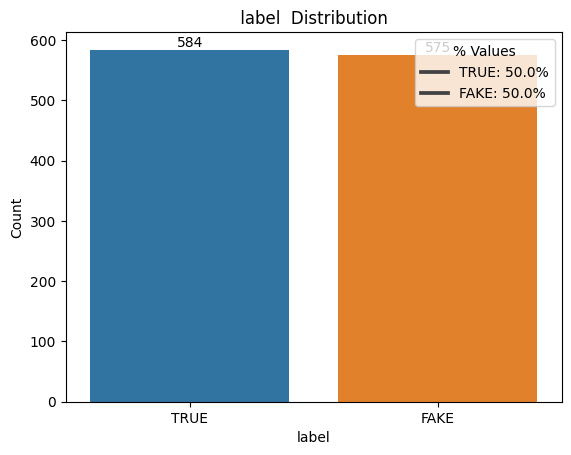

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rating değerlerinin frekanslarını sayısını alma
num = df['label'].value_counts()

ax = sns.barplot(x=num.index, y=num.values, order=num.index)
ax.bar_label(ax.containers[0])
plt.title(' label  Distribution ')
plt.ylabel('Count')

# Yüzdelik değerleri hesapla
yuzde = (num / num.sum()).round(2)
l = [f'{i}: {v*100}%' for i, v in yuzde.items()]
plt.legend(l, title="% Values")
plt.show()

# Text preproccesing

In [55]:
df['title_text'][50]

'Is 5G Safe? 5G is a new radio technology, so naturally those most concerned about environmental health have been asking if it\'s safe. New antennas are going up outside apartment windows, and most of us tend to keep our phones quite close to us at all times. There\'s a lot of science on the subject, and also a lot of pseudo-science. We try to cut through the bull to explain the safety issues with radio waves in general, cell phones in particular, and what makes 5G different.We\'re going to start by explaining the terminology used for this topic, because there are some common misconceptions about what these terms mean. Then we\'re going to cover radio waves in general, because there are important, relevant principles that apply to all radio waves, including all cell phones, and all 5G technology. Finally, we\'ll get into what makes "5G" unique.Also, if you\'re concerned about this topic because you came across an alarming article or TV segment about the dangers of 5G, make sure that wa

In [56]:
def preprocess_text(df):
    df['title_text'] = df['title_text'].str.lower()  # Tüm metni küçük harfe dönüştürür
    df['title_text'] = df['title_text'].str.replace('[^\w\s]', '', regex=True)  # Noktalama işaretlerini kaldırır
    df['title_text'] = df['title_text'].str.replace('\d+', '', regex=True)  # Rakamları kaldırır
    df['title_text'] = df['title_text'].str.replace('\n', ' ', regex=True)  # Satır sonlarını boşlukla değiştirir
    df['title_text'] = df['title_text'].str.replace('\r', '', regex=True)  # Carriage return karakterlerini kaldırır
    df['title_text'] = df['title_text'].str.replace('\s+', ' ', regex=True)  # Fazla boşlukları tek boşlukla değiştirir
    df['title_text'] = df['title_text'].str.strip()  # Başta ve sondaki boşlukları kaldırır
    return df

df = preprocess_text(df)

In [57]:
df['title_text'][50]

'is g safe g is a new radio technology so naturally those most concerned about environmental health have been asking if its safe new antennas are going up outside apartment windows and most of us tend to keep our phones quite close to us at all times theres a lot of science on the subject and also a lot of pseudoscience we try to cut through the bull to explain the safety issues with radio waves in general cell phones in particular and what makes g differentwere going to start by explaining the terminology used for this topic because there are some common misconceptions about what these terms mean then were going to cover radio waves in general because there are important relevant principles that apply to all radio waves including all cell phones and all g technology finally well get into what makes g uniquealso if youre concerned about this topic because you came across an alarming article or tv segment about the dangers of g make sure that wasnt actually russian propaganda designed t

In [58]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [59]:
example=TextBlob(df['text'][4])
df['text'][4],example.sentiment

('In a situation where there is no choice — such as if the grandparent lives with the grandchildren — then the family should do everything they can to try to limit the risk of COVID-19. The grandchildren should be isolated as much as possible, as should the parents, so that the overall family risk is as low as possible. Everyone should wash their hands very frequently throughout the day, and surfaces should be wiped clean frequently. Physical contact should be limited to the absolutely necessary; as wonderful as it can be to snuggle with Grandma or Grandpa, now is not the time.',
 Sentiment(polarity=0.12956709956709958, subjectivity=0.5614285714285715))

In [60]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0.20:
        sentiment = 'pozitif'
    elif polarity < -0.20:
        sentiment = 'negatif'
    else:
        sentiment = 'natural'

    polar = polarity
    return pd.Series([sentiment, polar])

df[['sentiment', 'polarity']] = df['title_text'].apply(lambda x: get_sentiment(x))

In [61]:
df.head(2)

,title,text,source,label,title_text,sentiment,polarity
0,How long is it between when a person is expose...,Recently published research found that on aver...,https://www.health.harvard.edu/,TRUE,how long is it between when a person is expose...,natural,-0.050000
1,Multiple vaccine corporations are working on a...,"Over the past week, novel coronavirus has domi...",https://www.newstarget.com,FAKE,multiple vaccine corporations are working on a...,natural,0.076167


In [69]:
from PIL import Image
from wordcloud import STOPWORDS,WordCloud

def cloud(data,bgcolor): 
    plt.figure(figsize=(10,10))
    mask=np.array(Image.open('covid.jpg'))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask)
    wc.generate(''.join(data))
    plt.imshow(wc)
    
    plt.title(f"  İşlenen Metin Sayısı: {len(data)}")
    plt.axis('off')
    plt.show()

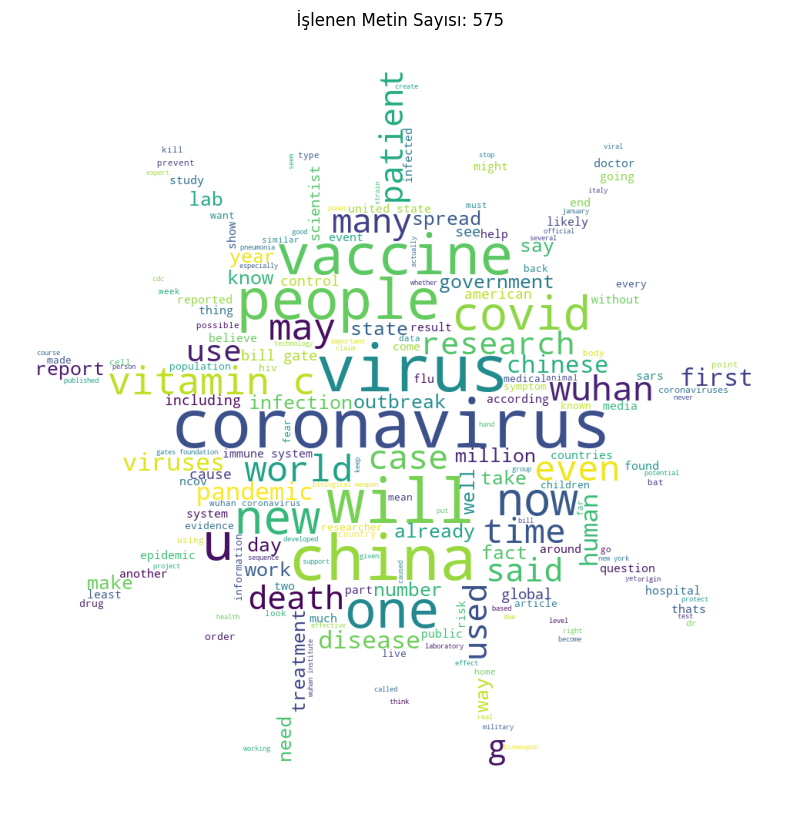

In [70]:
import numpy as np 
fake_titles = df[df['label'] == 'FAKE']['title_text']
cloud(fake_titles,'white')

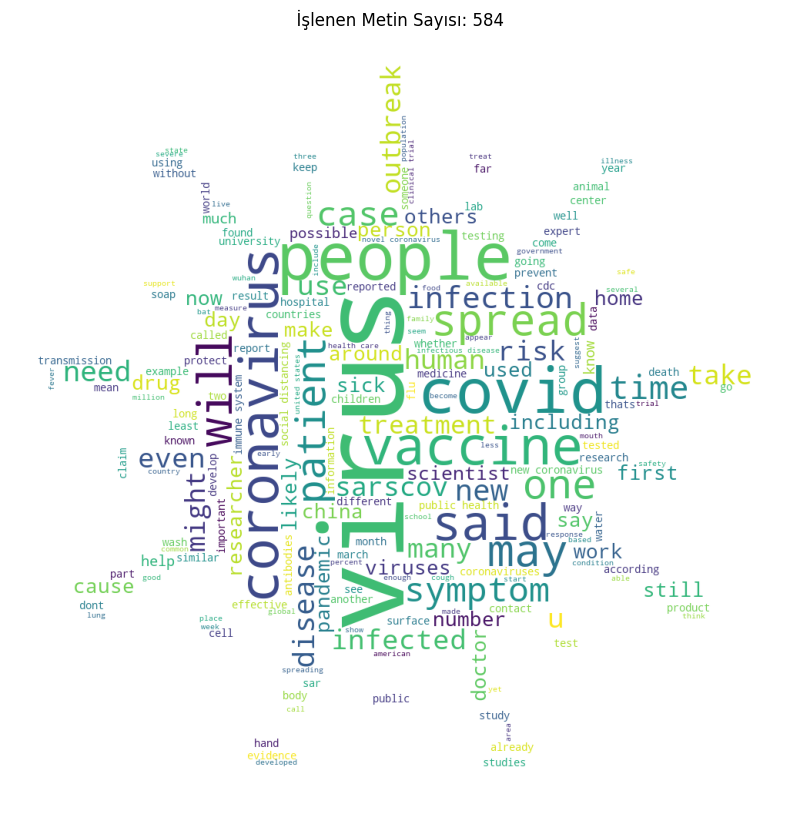

In [71]:
true_titles = df[df['label'] == 'TRUE']['title_text']
cloud(true_titles,'white')

 # Modeling

In [78]:
import warnings
warnings.filterwarnings('ignore')
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
deger= tfidf.fit_transform(df['title_text'])

In [80]:
X = deger
y = df.label.values

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, shuffle=False)

clf = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=3, max_iter=300).fit(X_train, y_train)

fake_news_model = open('fake_news_model.sav', 'wb')
pickle.dump(clf, fake_news_model)
fake_news_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.0s remaining:   31.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


In [83]:
filename = 'fake_news_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

saved_clf.score(X_test, y_test)

0.9396551724137931

In [84]:
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.9396551724137931
              precision    recall  f1-score   support

        FAKE       0.94      0.95      0.94       183
        TRUE       0.94      0.93      0.94       165

    accuracy                           0.94       348
   macro avg       0.94      0.94      0.94       348
weighted avg       0.94      0.94      0.94       348



<Axes: >

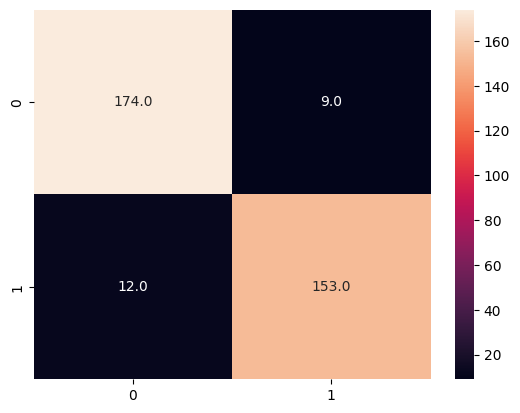

In [85]:
import seaborn as sns 
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='.1f')

In [86]:
# sonuç iyi 